# LSTM Regression

---

Aditya Marathe

## Imports

In [269]:
import sys

In [ ]:
%matplotlib inline

import h5py
import pandas as pd

import numpy as np
import numpy.typing as npt

import tensorflow as tf
from tensorflow import keras

from sklearn import preprocessing

import matplotlib as mpl
import matplotlib.pyplot as plt

**Local**

In [ ]:
sys.path.insert(1, './../')

import ana
from utils import *
from transforms import *

In [ ]:
ana.init_global_plotting_style()

**Version and hardware**

In [ ]:
print(f'Python {sys.version}\n')
print(f'H5Py {h5py.__version__}')
print(f'Pandas {pd.__version__}')
print(f'NumPy {np.__version__}')
print(f'Matplotlib {mpl.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

H5Py 3.10.0
Pandas 2.1.2
NumPy 1.26.1
Matplotlib 3.8.1


## Data

In [ ]:
ds = Datasets()

In [ ]:
data = ana.NOvAData.init_from_copymerge_h5([ds.COPYMERGED_C9_DIR, ds.COPYMERGED_C10_DIR])

In [ ]:
data.fill_ana_track_kinematics(inplace=True)

In [ ]:
cuts = ana.Cuts.init_nova_cuts()
cuts.print_all_cuts()

Detector QualityData QualityCVN PID ScoreContainmentCosmic Rej.Veto


In [ ]:
# Cuts
data.table = cuts.apply_cut('Detector Quality', data.table)
data.table = cuts.apply_cut('Data Quality', data.table)
data.table = cuts.apply_cut('Cosmic Rej.', data.table)
data.table = cuts.apply_cut('Veto', data.table)
data.table = cuts.apply_cut('CVN PID Score', data.table)
data.table = cuts.apply_cut('Containment', data.table, passed=False)

In [ ]:
# Transforms
data.table = tf_290124_positive_energies(data.table)
data.table = tf_290124_valid_pid(data.table)
data.table = tf_050224_max_prongs(data.table, max_prongs=10)

In [ ]:
def tf_050224_add_padding(
        df: pd.DataFrame, 
        max_prongs: int = 5
    ) -> pd.DataFrame:
    df_copy = df.copy()

    targets = [
        'rec.trk.kalman.tracks.dir.x',
        'rec.trk.kalman.tracks.dir.y',
        'rec.trk.kalman.tracks.dir.z',
        'rec.trk.kalman.tracks.start.x',
        'rec.trk.kalman.tracks.start.y',
        'rec.trk.kalman.tracks.start.z',
        'rec.trk.kalman.tracks.len',
        'rec.trk.kalman.tracks.muonid',
        'rec.trk.kalman.tracks.rempid',
        'rec.trk.kalman.tracks.nhit',
        'rec.trk.kalman.tracks.nhitx',
        'rec.trk.kalman.tracks.nhity',
        'rec.trk.kalman.tracks.calE',
        'rec.trk.kalman.tracks.overlapE',
        'rec.trk.kalman.tracks.nplane',
        'rec.trk.kalman.tracks.maxplanecont',
        'ana.trk.kalman.tracks.cosBeam',
        'ana.trk.kalman.tracks.PtToPmu',
        'ana.trk.kalman.tracks.Pt',
        'ana.trk.kalman.tracks.Qsquared',
        'ana.trk.kalman.tracks.W'
    ]

    

    def add_padding(row):
        for target in targets:
            padding = max_prongs - len(row[target])
            row[target] = np.concatenate((row[target], [0] * padding))
        return row

    return df_copy.apply(add_padding, axis=1)

In [ ]:
data.table = tf_050224_add_padding(data.table, max_prongs=10)

In [ ]:
data.table['rec.mc.nu.E'].fillna(0, inplace=True)

In [ ]:
data.table = data.table[data.table['rec.mc.nu.E'] <= 5]

In [ ]:
x_data = [
	# Old EE
	# 'rec.energy.numu.E',
	# 'rec.energy.numu.recomuonE',
	# 'rec.energy.numu.calccE',
	# 'rec.energy.numu.trkccE',

	# New LSTM EE
	# 'rec.energy.numu.lstmmuon',
	# 'rec.energy.numu.lstmnu',

	# Hadronic stuff
	'rec.energy.numu.hadcalE',
	'rec.energy.numu.hadtrkE',
	'rec.energy.numu.hadclust.calE',
	# 'rec.energy.numu.regcvnhadE',
	'rec.energy.numu.hadclust.nhit',
	
	# Containment stuff
	# 'rec.sel.contain.kalfwdcell',
	# 'rec.sel.contain.kalbakcell',
	# 'rec.sel.contain.cosfwdcell',
	# 'rec.sel.contain.cosbakcell',
	
	# CVN Pre-selection PID
	'rec.sel.cvnloosepreselptp.cosmicid',
	'rec.sel.cvnloosepreselptp.ncid',
	'rec.sel.cvnloosepreselptp.nueid',
	'rec.sel.cvnloosepreselptp.numuid',
	
	# Reconstructed Muon ID, and SC PID
	'rec.sel.remid.pid',
	'rec.sel.scann.scpid',

	# Slice
	'rec.slc.calE',
	'rec.slc.nhit',
	# 'rec.slc.firstplane',
	# 'rec.slc.lastplane',
	# 'rec.slc.ncontplanes',

	# Kalman tracks (const. len.)
	'rec.trk.kalman.ntracks',
	'rec.trk.kalman.ntracks2d',

	# Kalman tracks (varying len.)
	'rec.trk.kalman.tracks.calE',
	'rec.trk.kalman.tracks.overlapE',

	'rec.trk.kalman.tracks.nplane',
	'rec.trk.kalman.tracks.maxplanecont',

	'rec.trk.kalman.tracks.nhit',
	'rec.trk.kalman.tracks.nhitx',
	'rec.trk.kalman.tracks.nhity',

	'rec.trk.kalman.tracks.dir.x',
	'rec.trk.kalman.tracks.dir.y',
	'rec.trk.kalman.tracks.dir.z',
	'rec.trk.kalman.tracks.start.x',
	'rec.trk.kalman.tracks.start.y',
	'rec.trk.kalman.tracks.start.z',

	'rec.trk.kalman.tracks.len',

	'rec.trk.kalman.tracks.muonid',
	'rec.trk.kalman.tracks.rempid',

	# Kalman track (derived)
	# 'ana.trk.kalman.tracks.cosBeam',
	'ana.trk.kalman.tracks.PtToPmu',
	# 'ana.trk.kalman.tracks.Pmu',
	# 'ana.trk.kalman.tracks.Pt',
	# 'ana.trk.kalman.tracks.Qsquared',
	# 'ana.trk.kalman.tracks.W',  --> Too many NaNs
]

x_data = [
	# Input 1
	# 'rec.energy.numu.hadcalE',
	# 'rec.energy.numu.hadtrkE',
	# 'rec.energy.numu.hadclust.calE',
	# 'rec.energy.numu.hadclust.nhit',

	# 'rec.sel.cvnloosepreselptp.cosmicid',
	# 'rec.sel.cvnloosepreselptp.ncid',
	# 'rec.sel.cvnloosepreselptp.nueid',
	# 'rec.sel.cvnloosepreselptp.numuid',

	'rec.sel.remid.pid',
	'rec.sel.scann.scpid',

	'rec.trk.kalman.ntracks',
	'rec.trk.kalman.ntracks2d',

	'rec.trk.kalman.tracks.calE',
	'rec.trk.kalman.tracks.overlapE',

	'rec.trk.kalman.tracks.nplane',
	'rec.trk.kalman.tracks.maxplanecont',

	'rec.trk.kalman.tracks.nhit',
	'rec.trk.kalman.tracks.nhitx',
	'rec.trk.kalman.tracks.nhity',

	'rec.trk.kalman.tracks.dir.x',
	'rec.trk.kalman.tracks.dir.y',
	'rec.trk.kalman.tracks.dir.z',

	'rec.trk.kalman.tracks.start.x',
	'rec.trk.kalman.tracks.start.y',
	'rec.trk.kalman.tracks.start.z',

	'rec.trk.kalman.tracks.len',

	'rec.trk.kalman.tracks.muonid',
	'rec.trk.kalman.tracks.rempid',
	
	'ana.trk.kalman.tracks.PtToPmu',

	# Input 2
	'rec.slc.calE',
	'rec.slc.nhit'

]

y_data = [
	'rec.mc.nu.E'
]

In [ ]:
# Flatten the data
numpy_table_x = np.vstack(
    data.table[x_data].apply(lambda row: np.hstack(row), axis=1).to_numpy()
)
numpy_table_y = data.table[y_data].to_numpy().flatten()

In [ ]:
n = len(numpy_table_x)

In [ ]:
# Train test split
train_x = numpy_table_x[:int(n * 0.8)]
train_y = numpy_table_y[:int(n * 0.8)]

test_x = numpy_table_x[int(n * 0.8):]
test_y = numpy_table_y[int(n * 0.8):]

In [ ]:
train_x.shape

(7458, 176)

In [ ]:
train_y.shape

(7458,)

## Model

In [212]:
binning = np.linspace(0, 5, 50 + 1)

In [213]:
values, edges = np.histogram(
    data.table['rec.mc.nu.E'],
    bins=binning
)

In [214]:
values = values + 1

In [215]:
bin_number = np.digitize(
    data.table['rec.mc.nu.E'],
    bins=binning
)

In [242]:
weights = 1 / values

In [243]:
for i in range(binning.shape[0] - 1):
    bin_number[bin_number == i] = weights[i]

In [244]:
weights = bin_number

In [245]:
values.shape

(50,)

In [246]:
weights.shape

(9323,)

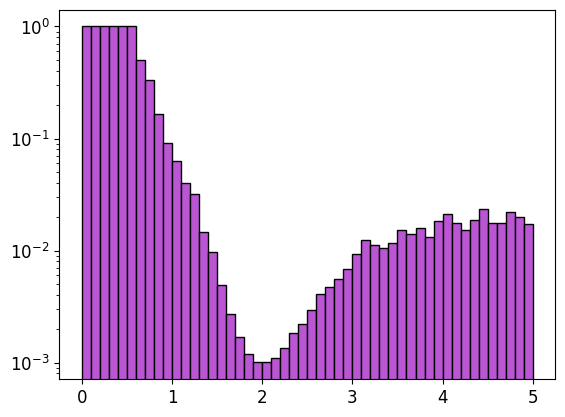

In [247]:
plt.bar(x=edges[:-1], height=1 / values, width=np.diff(edges), align='edge', fc='MediumOrchid', ec='black')
plt.yscale('log')

In [248]:
weights.max()

50

In [249]:

def build_compile_model(
        input_1_shape,
        input_2_shape,
    ) -> keras.models.Model:
    # Branch #1
    branch_1_input = keras.layers.Input(shape=input_1_shape)

    # Pre-processing
    branch_1 = keras.layers.BatchNormalization()(branch_1_input)
    branch_1 = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu
    )(branch_1)
    branch_1 = keras.layers.BatchNormalization()(branch_1)
    branch_1 = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu
    )(branch_1)
    branch_1 = keras.layers.BatchNormalization()(branch_1)
    branch_1 = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu
    )(branch_1)
    branch_1 = keras.layers.BatchNormalization()(branch_1)
    
    # LSTM
    branch_1 = keras.layers.Reshape((1, 128))(branch_1)
    branch_1 = keras.layers.LSTM(32)(branch_1)

    # Branch #2
    branch_2_input = keras.layers.Input(shape=input_2_shape)
    branch_2_input = keras.layers.Reshape((2,))(branch_2_input)

    branch_concat = keras.layers.concatenate([branch_1, branch_2_input])

    # Post-processing
    branch_concat = keras.layers.BatchNormalization()(branch_concat)
    branch_concat = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu
    )(branch_concat)
    branch_concat = keras.layers.BatchNormalization()(branch_concat)
    branch_concat = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu
    )(branch_concat)
    branch_concat = keras.layers.BatchNormalization()(branch_concat)
    branch_concat = keras.layers.Dense(
        units=128, 
        activation=keras.activations.relu
    )(branch_concat)
    branch_concat = keras.layers.BatchNormalization()(branch_concat)

    # Output
    output = keras.layers.Dense(
        units=1, 
        activation=keras.activations.linear
    )(branch_concat)

    # Model
    model = keras.models.Model(
        name='model',
        inputs=[branch_1_input, branch_2_input],
        outputs=output
    )

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1E-3),
        loss=keras.losses.mean_squared_error,
        weighted_metrics=[
            keras.metrics.MeanSquaredError(name='mse'),
            keras.metrics.MeanAbsoluteError(name='mae')
        ]
    )

    model.summary()

    return model


In [257]:
model = build_compile_model(input_1_shape=(train_x.shape[1] - 2,), input_2_shape=(2,))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 174)]        0           []                               
                                                                                                  
 batch_normalization_100 (Batch  (None, 174)         696         ['input_39[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 dense_87 (Dense)               (None, 128)          22400       ['batch_normalization_100[1][0]']
                                                                                                  
 batch_normalization_101 (Batch  (None, 128)         512         ['dense_87[1][0]']           

In [258]:
epochs = 100

In [259]:
history = model.fit(
    [train_x[:, :train_x.shape[1] - 2], train_x[:, train_x.shape[1] - 2:]],
    train_y,
    # sample_weight=weights,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100


187/187 [==============================] - 6s 9ms/step - loss: 2.5243 - mse: 2.5243 - mae: 1.2435 - val_loss: 0.4633 - val_mse: 0.4633 - val_mae: 0.4154
Epoch 2/100
187/187 [==============================] - 1s 5ms/step - loss: 0.6220 - mse: 0.6220 - mae: 0.5249 - val_loss: 0.4661 - val_mse: 0.4661 - val_mae: 0.4337
Epoch 3/100
187/187 [==============================] - 1s 5ms/step - loss: 0.5581 - mse: 0.5581 - mae: 0.4879 - val_loss: 0.4775 - val_mse: 0.4775 - val_mae: 0.4075
Epoch 4/100
187/187 [==============================] - 1s 7ms/step - loss: 0.5078 - mse: 0.5078 - mae: 0.4675 - val_loss: 0.4468 - val_mse: 0.4468 - val_mae: 0.4232
Epoch 5/100
187/187 [==============================] - 1s 5ms/step - loss: 0.4578 - mse: 0.4578 - mae: 0.4400 - val_loss: 0.4903 - val_mse: 0.4903 - val_mae: 0.4347
Epoch 6/100
187/187 [==============================] - 5s 27ms/step - loss: 0.4441 - mse: 0.4441 - mae: 0.4309 - val_loss: 0.4280 - val_mse: 0.4280 - val_mae: 0.4020
Epoch 7/100
187/187 [

In [264]:
prediction = model.predict((test_x[:, :train_x.shape[1] - 2], test_x[:, train_x.shape[1] - 2:]))

59/59 [==============================] - 0s 3ms/step


In [265]:
test_y.shape

(1865,)

In [266]:
prediction.shape

(1865, 1)

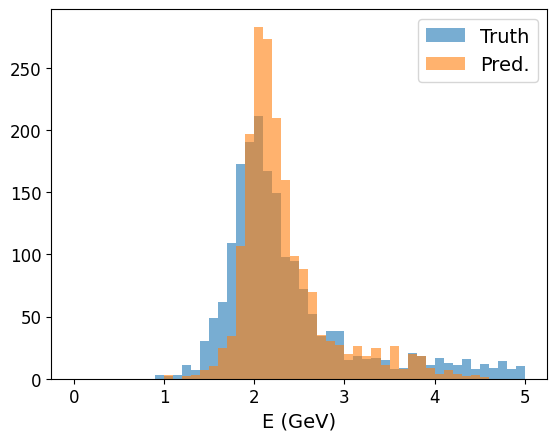

In [267]:
plt.hist(test_y, bins=np.linspace(0, 5, 50 + 1), alpha=0.6, label='Truth')
plt.hist(prediction.flatten(), bins=np.linspace(0, 5, 50 + 1), alpha=0.6, label='Pred.')
plt.xlabel('E (GeV)')
plt.legend();

# --------------------------------

In [268]:

build_compile_model(
    input_1_shape=(None,),
    input_2_shape=(2,)
)

ValueError: Input has undefined `axis` dimension. Received input with shape (None, None) and axis=(1,)